# Lab 15

Today, we will continue our discussion about **_Support Vector Machines_** and discuss kernel methods. Today's goals are: 

0. Define support vectors
1. Operationalize 
2. Use `sklearn` build an SVM
3. Define kernels


### Last time - Motivating SVM 

Last lab, we looked at Maximal Margins for nicely (or linearly) separated data. Then we explored how to "relax" our desire to have a "hard" boundary. This softening is called the _soft-margin classification._

Today we will add a bit more terminology to our discussion and use the `sklearn` implementation for SVM to classify our data. 

### Imports for Today

Today we are working with two (constructed) datasets from Lab 14. 

We begin as usual, importing the packages and data that we need. Plot the first dataset `new_data` and note at least 2 observations about the data. 

In [1]:
## Import block
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import numpy as np
from numpy import linalg as LA
import pandas as pd

import random 

from sklearn.svm import SVC
from sklearn.datasets import make_circles

In [2]:
## Functions for later use

def plot_svc_decision_function(SVM, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # Create grid to evaluate SVM model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = SVM.decision_function(xy).reshape(X.shape)
    
    # Plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # Plot support vectors
    if plot_support:
        ax.scatter(SVM.support_vectors_[:, 0],
                   SVM.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none', edgecolors='k');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

# Adapted from https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html

def plot_supports(SVM, ax=None):
    """Plot the decision function for a 2D SVC"""
    
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # Plot support vectors
    ax.scatter(SVM.support_vectors_[:, 0], 
               SVM.support_vectors_[:, 1],
               s=300, linewidth=1, facecolors='none', edgecolors='k');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [ ]:
# For function testing 




In [19]:
## Import Data

new_data = pd.read_csv("../Lab14-SVM/lab14data.csv", sep = ",")
new_data["group"] = -1*new_data["group"]
new_data_np = new_data.to_numpy()

extra_data = pd.read_csv("../Lab14-SVM/extra_lab14data.csv", sep = ",")
extra_data["group"] = -1*extra_data["group"]
extra_data_np = extra_data.to_numpy()

data_all = np.vstack([new_data_np,extra_data_np])

## x-values for plotting
x = np.linspace(-3.1,3.15,1000)

In [ ]:
# Plot new_data
#
# What do you notice? 

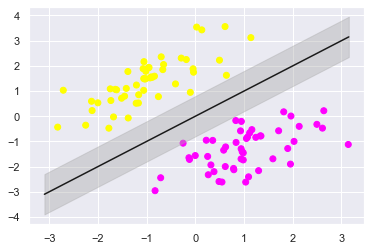

In [7]:
# Inflating the green boundary:
inflate_width = 0.8

plt.scatter(new_data["myst"],new_data["mysty"],
            c=new_data["group"],cmap = "spring")
plt.plot(x,x,'-k')
plt.fill_between(x, x - inflate_width, x + inflate_width, 
                 edgecolor='none', color='#AAAAAA', alpha=0.4)

### Definitions 

Last time, we played with existing boundary options and added a margin around it. Typically in SVM, we find the points that are closest to the line (plane or hyperplane) that will separate the two groups. These points are called the _support vectors._ 

One of the margins is the positive margin, assigning all data points on its side the class `1` (which means one margin width above the bounary). The other margin is the negative margin assigning all all data points on its side the class `-1` (which means one margin width below the boundary). The central boundary line is called the _decision boundary._

For each class, there will be support vectors for class `1` and support vectors for class `-1`. They will be sitting on the edge of their respective side of the margin. Running equally between them will be the decision boundary. 

Any points within the the boundary are called _slack variables_ which fall into two groups:
* Those on the wrong "side" of the decision boundary
* Those on the  right "side" of the line BUT are within the margin

Slack variables accumulate penalties (or costs) denoted as $\xi_i$ (pronounced "ex-cee") as follows:
* Those on the wrong "side" of the decision boundary -- **greater than 1**
* Those on the  right "side" of the line BUT are within the margin -- **greater than 0, but less than 1**

In fact, we can extend these costs (or $\xi_i$) to all points: 
* Data points exactly on the margin (ie. the support vectors) -- **there is no penalty**
* Data points on the "right" side of the line and not on the margin -- **there is no penalty**

## Penalty terms 

In SVM we are trying to balance two desires:
* Have the biggest possible margin, ie. $margin~size$
* Limit the costs of the slack variables ie. $\sum \xi_i$

The latter is what is known as the _penalty term._ 

In our balancing, we may want to limit (or increase) the effect of the penalty term. We control this with a parameter $C>0$, rewriting our penalty term as $C \sum \xi_i$. 
* If $C=0$, how much impact does the penalty term have?
* If $C$ is large, how much impact does the penalty term have?

(A plce for your notes on the above questions)

## SVM output

The goal of SVM is to find the decision boundary that maximizes the margin subject to the penalty term. So we need a way to encode the distance from points to the decision boundary, which the dot product between the coefficients of a line with the associated components of the data points gives us. This means that (after some serious multivariable calculus) we can define the classifier resuling from linear SVM as:

\begin{equation}
\textrm{classifier}(x) = \beta_0 + \sum_{i} \alpha_i (x\cdot x_i)
\end{equation}

To estimate the values for all the $\alpha_i$'s we need to take the dot product between our new point and each of the data points. However, SVM only relies on the support vectors, which means that $\alpha_i = 0$ unless the $i^{\textrm{th}}$ data point is a support vector. So the SVM classifier can be written as: 

\begin{equation}
\textrm{classifier}(x) = \beta_0 + \sum_{s, \textrm{support vectors}} \alpha_s (x\cdot x_i)
\end{equation}

_Note:_ This markdown block is based heavily on page 351 in _ISLR._

## SVM in  `sklearn` 

Let's step back from the terminology and see what we actually get with SVM. We begin with the nicely separated data from teh first part of Lab 14. In the later part of this section, we will look the full dataset (with the points that seem to mix). 

Just with our previous algorithms in `sklearn` there is a phase of determining the details of our models and then fitting that model to the actual data. 

**Note:** SVM is can be called `SVC` for _support vector classifier._

_note:_ this may take a second to run. 

In [8]:
# Separate our data into inputs and class labels
inputs = new_data_np[:,:2]
classes = new_data_np[:,2]

# Create the details of the model
# Note that C is very large here! 
first_SVM = SVC(kernel="linear", C=1E10)

# Fit the model to our data
first_SVM.fit(inputs, classes)

SVC(C=10000000000.0, kernel='linear')

### Outputs of SVM

We've talked about how SVM relies on the support vectors. Let's see which of our data points are the support vectors. First we will print the numerical information and then plot our data with the support vectors denoted with circles around the points: 

In [9]:
first_SVM.support_vectors_

array([[-0.25264011, -1.07106919],
       [-0.10359216,  0.94862731],
       [-1.77674738, -0.47515769]])

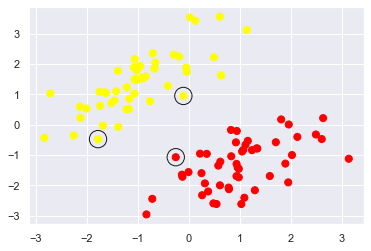

In [10]:
plt.scatter(inputs[:, 0], inputs[:, 1], c=classes, s=50, cmap='autumn')
plot_supports(first_SVM);

Does the above plot surprise you? 

We can also visualize the decision boundary with its margins (and the support vectors still marked:

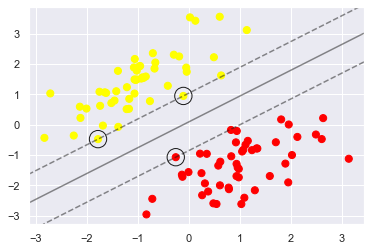

In [11]:
plt.scatter(inputs[:, 0], inputs[:, 1], c=classes, s=50, cmap='autumn')
plot_svc_decision_function(first_SVM, plot_support=True);

#### Quick explanation about this picture 

One way to think about support vectors is that they are the smallest number of points that uniquely define the boundary. The smallest number that you can possibly have is 3: two for one class and one for the other class. 

Suppose that you only had two support vectors: one per class. There would be infinitely many lines that would be halfway between these two points. The addition of the third support vector effectly chooses the tilt (or slope) of the boundary that is halfway between the two support vectors in one class and the remaining support vector. 

Notice in this picture that the line defined by the two red support vectors is parallel to the boundary and the other margin. The existence of the two red support vectors is determining that tilt. 

#### Your turn

So far we've only used the nicely separated data with one value for $C$. Repeat this process with $C=0$ and with two other values for $C$. Note your observations. 

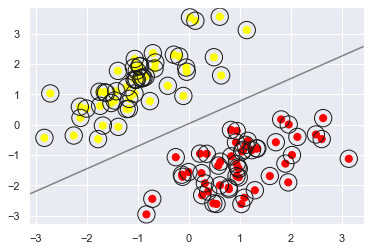

In [12]:
# Create the details of the model
# Set C = 0 
second_SVM = SVC(kernel="linear", C=1E-14)

# Fit the model to our data
second_SVM.fit(inputs, classes)

# Plot the decision boundary with the supports labeled 
plt.scatter(inputs[:, 0], inputs[:, 1], c=classes, s=50, cmap='autumn')
plot_svc_decision_function(second_SVM, plot_support=True);

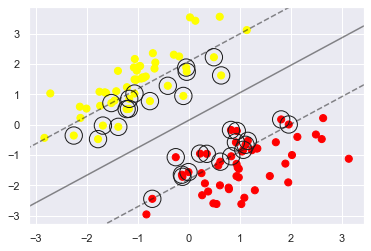

In [13]:
# Create the details of the model
# Set C equal to another positive value 
third_SVM = SVC(kernel="linear", C=0.02)

# Fit the model to our data
third_SVM.fit(inputs,classes)

# Plot the decision boundary with the supports labeled 
plt.scatter(inputs[:, 0], inputs[:, 1], c=classes, s=50, cmap='autumn')
plot_svc_decision_function(third_SVM, plot_support=True);

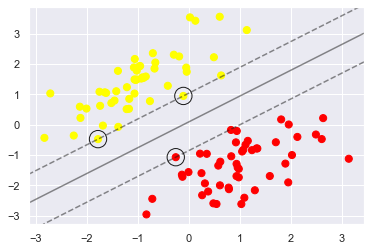

In [14]:
# Create the details of the model
# Set C equal to another positive value 
fourth_SVM = SVC(kernel="linear", C=1E20)

# Fit the model to our data
fourth_SVM.fit(inputs,classes)

# Plot the decision boundary with the supports labeled 
plt.scatter(inputs[:, 0], inputs[:, 1], c=classes, s=50, cmap='autumn')
plot_svc_decision_function(fourth_SVM, plot_support=True);

Next using the `data_all` variable, repeat this process with two of the values of $C$ from above. What happens? 

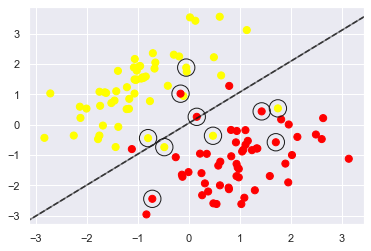

In [20]:
# Separate our data into inputs and class labels
inputs = data_all[:,:2]
classes = data_all[:,2]

# Create the details of the model
# Note that C is very large here! 
SVM1 = SVC(kernel="linear", C=1E10)

# Fit the model to our data
SVM1.fit(inputs, classes)

# Plot the decision boundary with the supports labeled 
plt.scatter(inputs[:, 0], inputs[:, 1], c=classes, s=50, cmap='autumn')
plot_svc_decision_function(SVM1, plot_support=True);

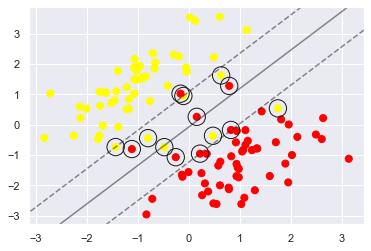

In [21]:
# Create the details of the model
# Set C = 0 
SVM2 = SVC(kernel="linear", C=2000)

# Fit the model to our data
SVM2.fit(inputs,classes)

# Plot the decision boundary with the supports labeled 
plt.scatter(inputs[:, 0], inputs[:, 1], c=classes, s=50, cmap='autumn')
plot_svc_decision_function(SVM2, plot_support=True);

In [ ]:
# Create the details of the model
# Set C equal to another positive value
SVM3 = SVC(kernel="linear", C=???)

# Fit the model to our data
SVM3.????

# Plot the decision boundary with the supports labeled 
plt.scatter(???)
plot_svc_decision_function(???, ???);

In [ ]:
# Create the details of the model
# Set C equal to another positive value
SVM4 = ???

# Fit the model to our data


# Plot the decision boundary with the supports labeled 


In [ ]:
# Code block for you 

## Kernels

Recall that the SVM classifier can be written as: 

\begin{equation}
classifier(x) = \beta_0 + \sum_{s, \textrm{support vectors}} \alpha_s (x\cdot x_i)
\end{equation}

The dot product is an example of a kernel function, in that it quantifies the similarity between two data points. If two data points are very similar their dot product will be close to the lengths of those two data points multiplied together. If they are completely different, then their dot product will be close to 0. 
* Another way to think of this is as vectors. If two vectors go in the same direction, their dot product is high. If they go in perpendicular directions, their dot product is 0. 

Anything that is a kernel can be written as $K(x,y)$ where the function $K$ tells us how to compute the similarity between two datapoints $x$ and $y$. This means that we can rewrite the SVM classifier as: 

\begin{equation}
classifier(x) = \beta_0 + \sum_{s, \textrm{support vectors}} \alpha_s K(x, x_i)
\end{equation}

The kernel just defines how we think about similarity between two points. 

The **kernel trick** is where we transform our data into a higher dimension based on the kernel that we've chosen. One popular one is the _radial basis function_ which effectively pulls data into a higher dimension such that the height that a data point is at is based on its distance from the origin. The _radial basis function_ is defined as:

\begin{equation}
rbf(x) = e^{-(x\cdot x)}
\end{equation}

Let's see this kernel trick in practice.

(Following example from [In-Depth: Support Vector Machines](https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html))

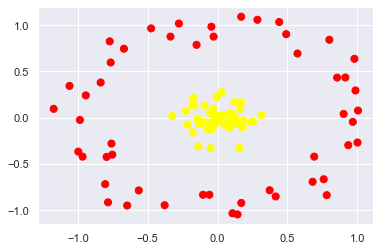

In [15]:
# Create a circular dataset
circ_data, circ_class = make_circles(100, factor=.1, noise=.1)

# Plot our new data
plt.scatter(circ_data[:, 0], circ_data[:, 1], c=circ_class, s=50, cmap='autumn')

#### Linear SVM

First let's apply a linear SVM to this dataset. In other words, let's try to separate this data with a straight line:

In [ ]:
# Create the details of the model
line_SVM = SVC(kernel="linear", C=1E6)

# Fit the model to our data
line_SVM.????

# Plot the decision boundary with the supports labeled 
plt.scatter(???)
plot_svc_decision_function(???, ???);

#### What do you notice? 

Is using a linear SVM a good idea? Why or why not?

*Your thoughts*

#### Kernel SVM

Now let's try applying the radial basis function. Recall that this kernel is equivalent to:

1. stretching our data into a higher dimension such that the points closer to the origin will pull away from those further away, and then...    
2. Computing linear SVM on the points in this higher dimensional space, and then ...    
3. Pushing the data back to the original space

In [22]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(circ_data, circ_class)

SVC(C=1000000.0)

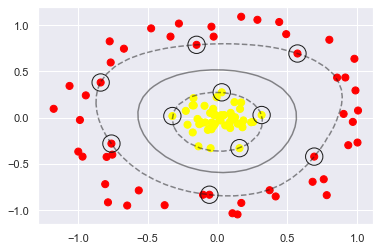

In [23]:
plt.scatter(circ_data[:, 0], circ_data[:, 1], c=circ_class, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=True)

### Next time

Next time, we will look at another kind of classification algorithm called **decision trees**. Later in the week, we will explore _ensemble methods._

### Final Thoughts

To finish up this lab, using the `data_all` variable, explore polynomial kernels from degree 2 to 5 using the sequence of three flags: `kernel='poly', degree=#, gamma='auto'`:

`pd_SVM = SVC(kernel='poly', degree = 2, gamma = 'auto')`


Do you think these polynomial kernels do a better job? Why or why not? Plot the one that you think is best for the overlapping data. Share your plot and thoughts in a post on **#lab15_submission** channel on slack with your answer. Your post must start with **Lab15** to get credit.  

If your have questions from this lab, post them to #lab_questions with the same preamble (i.e. starting with **Lab15**). If you have the same question, please use one of the emoji's to upvote the question. If you would like to answer someone's question, please use the thread function. This will tie your answer to their question. 

#### Resources consulted 

0. [ISLR](https://hastie.su.domains/ISLR2/ISLRv2_website.pdf)
1. [SDS 293 Notes by R. Jordan Crouser](http://www.science.smith.edu/~jcrouser/SDS293/)
2. [In-Depth: Support Vector Machines](https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html)
3. [SVM in `sklearn`](https://scikit-learn.org/stable/modules/svm.html)
4. [Plot different SVM classifiers in the iris dataset](https://scikit-learn.org/stable/auto_examples/svm/plot_iris_svc.html)
5. _Pattern Recognition and Machine Learning_ C. Bishop (2006)
6. [Stackoverflow regarding `samples_generator`](https://stackoverflow.com/questions/65898399/no-module-named-sklearn-datasets-samples-generator)